# Transfer Learning for Classifying Politicians

Since the politicians dataset is rather small, we would like to use a pre-trained network for our classification. However, the question asked is weather to use **all** the layers or just **part** of them as a strating point for out task. Another question raised here is weather to keep them **fix** or **fine-tune** them.

In this assignment we will dive into these questions (does is sound familiar to you? this is what the paper from research seminar is about).




In [ ]:
%matplotlib inline


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from __future__ import print_function, division

import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
plt.ion()   # interactive mode
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, models, transforms

import copy

### Loading the Data


In [ ]:
# Create a folder for our data
# The ! prefix runs this as a shell command
!mkdir data
!mkdir data/israeli_politicians

mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘data/israeli_politicians’: File exists


In [ ]:
# Download our dataset and extract it
import requests
from zipfile import ZipFile

url = 'https://github.com/omriallouche/ydata_deep_learning_2021/blob/main/data/israeli_politicians.zip?raw=true'
r = requests.get(url, allow_redirects=True)
open('./data/israeli_politicians.zip', 'wb').write(r.content)

with ZipFile('./data/israeli_politicians.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall(path='./data/israeli_politicians/')

### Datasets Loader


In [ ]:
# Define transformations that resize the images to 256x256, and normalize them.
# The means and standard deviations of each channel are the values used for normalization in ImageNet
means = [0.485, 0.456, 0.406]
stds = [0.229, 0.224, 0.225]

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(means, stds)
    ]),
    'val': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(means, stds)
    ]),
}

In [ ]:
data_dir = r'./data/israeli_politicians/'

# Create a dictionary of train and val datasets from images in folders
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=16,
                                             shuffle=True, num_workers=4),
    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=16,
                                          shuffle=False, num_workers=4)
  }

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print('dataset_sizes: ', dataset_sizes)

class_names = image_datasets['train'].classes
print('class_names:', class_names)

dataset_sizes:  {'train': 929, 'val': 234}
class_names: ['ayelet_shaked', 'benjamin_netanyahu', 'benny_gantz', 'danny_danon', 'gideon_saar', 'kostya_kilimnik', 'naftali_bennett', 'ofir_akunis', 'yair_lapid']


In [ ]:
# Check for the availability of a GPU, and use CPU otherwise
# If you are using Google Colab, be sure to change your runtime environment to GPU first.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Visualize a few images

Let's visualize a few training images so as to understand the data
augmentations.



In [ ]:
# A helper function to show an image from a tensor. We need to restore it to the original dynamic range before normalization
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(means)
    std = np.array(stds)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    fig = plt.figure(figsize=(5,3), dpi=300)
    plt.imshow(inp)
    if title is not None:
       plt.title(title, fontsize=5)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [ ]:
# Get a batch of training data - the data loader is a generator
inputs, classes = next(iter(dataloaders['train']))

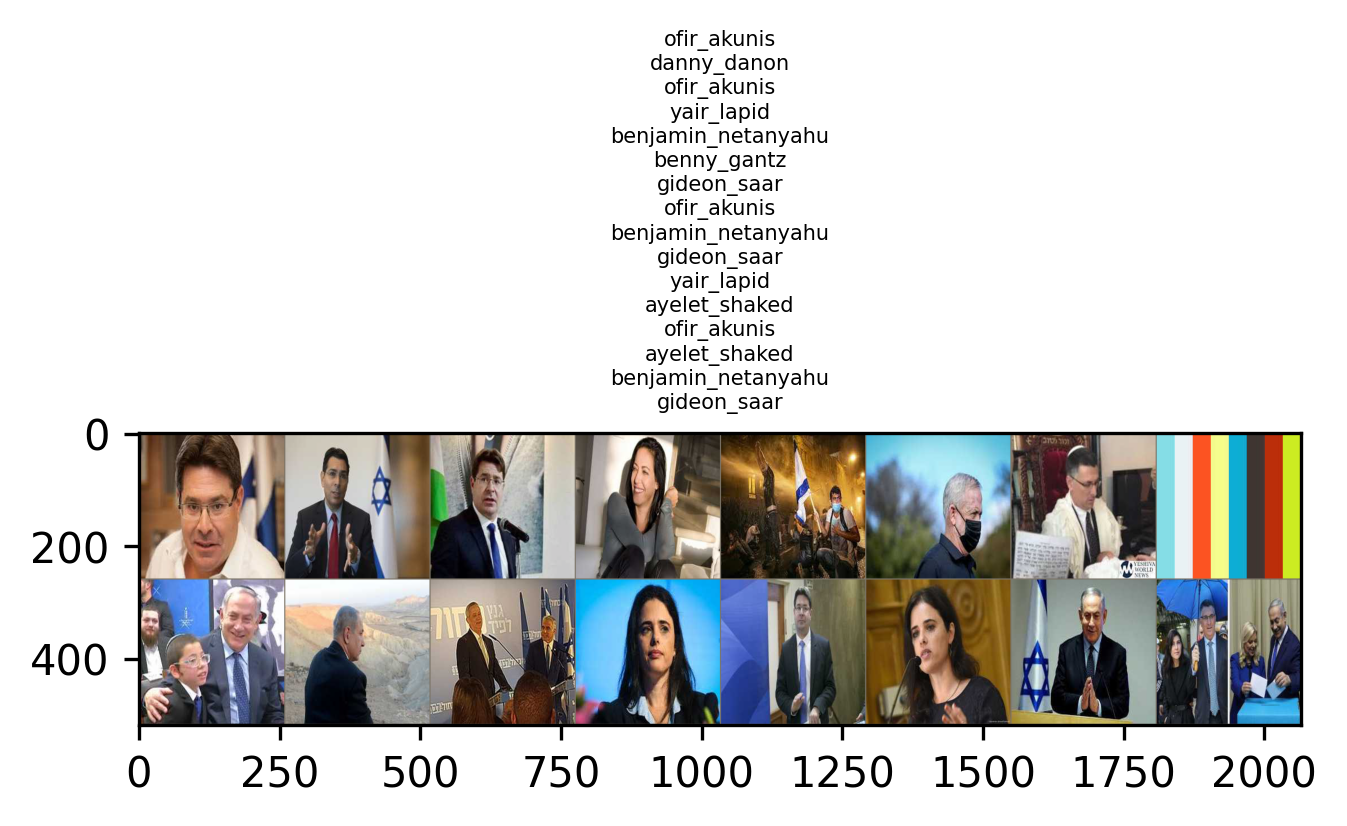

In [ ]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=8)

imshow(out, title='\n'.join([class_names[x] for x in classes]))

### Definine train_model

In [ ]:

def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25, silent=False):
    since = time.time()

    # Init variables that will save info about the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_res= np.zeros((2,num_epochs))
    val_res=np.zeros((2,num_epochs))
    dict_res={'train':train_res, 'val':val_res}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # Set model to training mode.
                model.train()
            else:
                # Set model to evaluate mode. In evaluate mode, we don't perform backprop and don't need to keep the gradients
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                # Prepare the inputs for GPU/CPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # ===== forward pass ======
                with torch.set_grad_enabled(phase=='train'):
                    # If we're in train mode, we'll track the gradients to allow back-propagation
                    outputs = model(inputs) # apply the model to the inputs. The output is the softmax probability of each class
                    _, preds = torch.max(outputs, 1) #
                    loss = criterion(outputs, labels)

                    # ==== backward pass + optimizer step ====
                    # This runs only in the training phase
                    if phase == 'train':
                        loss.backward() # Perform a step in the opposite direction of the gradient
                        optimizer.step() # Adapt the optimizer

                # Collect statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                # Adjust the learning rate based on the scheduler
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if not silent:
              print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            dict_res[phase][0,epoch]=epoch_loss
            dict_res[phase][1,epoch]=epoch_acc

            # Keep the results of the best model so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                # deepcopy the model
                best_model_wts = copy.deepcopy(model.state_dict())

        if not silent:
          print()

    time_elapsed = time.time() - since
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, dict_res


## Using a pretrained model - finetune all layers

This was the first task of the course, loading a model pretrained on ImageNet, and use it for our task.
We will use the VGG16 network, that won the ImageNet Challenge in 2016 and change the last linear layer to 9 output features:

In [ ]:
# We load a pretrain model with its weights. Alternatively, one might want to only load the model architecture.
model = models.vgg16(pretrained=True)
model.classifier[6] = nn.Linear(in_features=4096, out_features=9)

Let's review our change in the model:

In [ ]:

model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
!pip install torchsummary
from torchsummary import summary
summary(model.to(device), (3, 256, 256))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
    

In [ ]:
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
num_epochs = 10

In [ ]:
model,dict_res = train_model(model.to('cuda'),
                    dataloaders,
                       criterion,
                       optimizer_ft,
                       exp_lr_scheduler,
                       num_epochs=num_epochs,
                       silent=True)

Epoch 0/9
----------
Epoch 1/9
----------
Epoch 2/9
----------
Epoch 3/9
----------
Epoch 4/9
----------
Epoch 5/9
----------
Epoch 6/9
----------
Epoch 7/9
----------
Epoch 8/9
----------
Epoch 9/9
----------
Training complete in 3m 29s
Best val Acc: 0.824786


In [ ]:
def plot_convergence(dict_res, num_epochs):
  fig, axes = plt.subplots(1, 2, figsize=(14,4))
  types=['Loss', 'Accuracy']
  plt.subplot(1,2,1); plt.plot(dict_res['train'][0]); plt.plot(dict_res['val'][0]); plt.title('Loss'); plt.legend(['train','val'])
  plt.subplot(1,2,2); plt.plot(dict_res['train'][1]); plt.plot(dict_res['val'][1]); plt.title('Accuracy'); plt.legend(['train','val'])


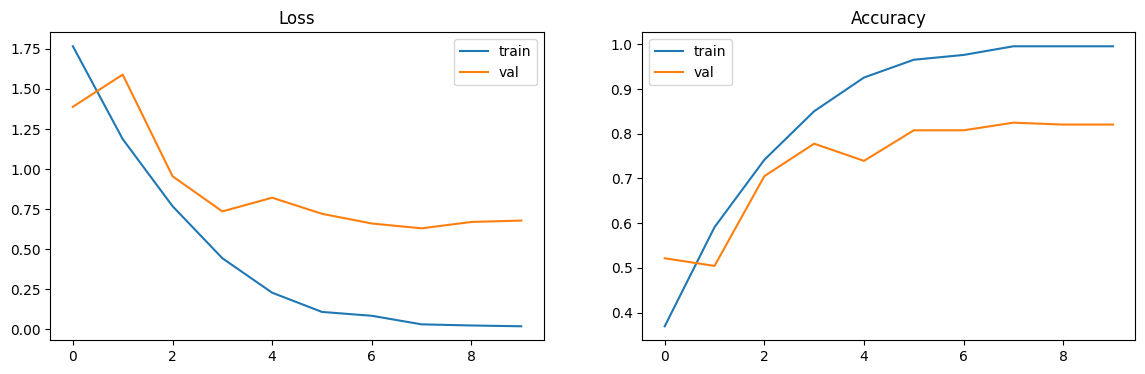

In [ ]:
plot_convergence(dict_res,num_epochs ); plt.show()
#0.81

## (1) Using a pretrained model - fixed NN feature (30 points)
Use pre-trained VGG16 model with fixed weights of all layers (up to the last one, of course).

**Do not forget to load the model again, otherwise the training will start from where the last training stopped**

In [ ]:
def run_model(nn_model, num_epochs=10, lr=0.001):
    optimizer = optim.SGD(filter(lambda p: p.requires_grad, nn_model.parameters()), lr=lr, momentum=0.9)
    exp_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    nn_model, dict_res = train_model(nn_model.to('cuda'),
                        dataloaders,
                          criterion,
                          optimizer,
                          exp_scheduler,
                          num_epochs=num_epochs,
                          silent=True)

    plot_convergence(dict_res, num_epochs)
    return nn_model, dict_res

In [ ]:
model_1 = models.vgg16(pretrained=True)
model_1.classifier[6] = nn.Linear(in_features=4096, out_features=9)

### Here we see the structure of the model

In [ ]:
model_1

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
model_1.parameters()

<generator object Module.parameters at 0x7f34c81205f0>

In [ ]:
# fix the weights of all layers
for param in model_1.parameters():
    param.requires_grad = False

# training only the last layer
for param in model_1.classifier[6].parameters():
    param.requires_grad = True

summary(model_1.to(device), (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
             ReLU-14          [-1, 256,

Epoch 0/9
----------
Epoch 1/9
----------
Epoch 2/9
----------
Epoch 3/9
----------
Epoch 4/9
----------
Epoch 5/9
----------
Epoch 6/9
----------
Epoch 7/9
----------
Epoch 8/9
----------
Epoch 9/9
----------
Training complete in 1m 30s
Best val Acc: 0.576923


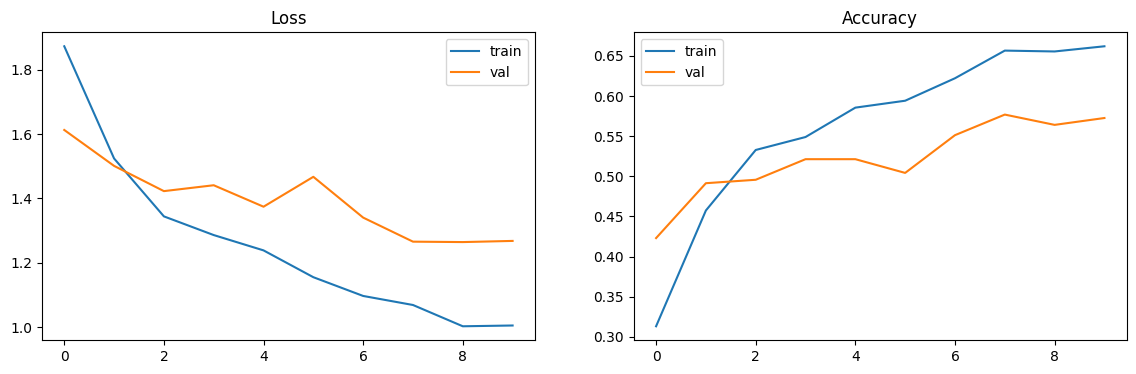

In [ ]:
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model_1.parameters()), lr=0.001, momentum=0.9)
exp_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model_1,dict_res_1 = train_model(model_1.to('cuda'),
                    dataloaders,
                       criterion,
                       optimizer,
                       exp_scheduler,
                       num_epochs=num_epochs,
                       silent=True)

plot_convergence(dict_res_1,num_epochs ); plt.show()

### Comments:

The results of model where wheights for all (except the last) layers were fixed from train on a different data are bad as expected.

## (2) Using a pretrained model - fixed some feature, tine-tune the rest (30 points)

Use pre-trained VGG16 model with fixed weights of **only part of the layers**. **Fine-tune** the rest of the layers. You should try different amount of layers as you wish. Try to get your best results.

### (2.1) Fix: all CCN part

In [ ]:
# Load a model
model_2 = models.vgg16(pretrained=True)
model_2.classifier[6] = nn.Linear(in_features=4096, out_features=9)

# fix the weights
for i in range(29):
  for param in model_2.features[i].parameters():
      param.requires_grad = False

# for i in range(6):
#   for param in model_2.classifier[i].parameters():
#       param.requires_grad = False

summary(model_2.to(device), (3, 256, 256))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
             ReLU-14          [-1, 256,

Epoch 0/9
----------
Epoch 1/9
----------
Epoch 2/9
----------
Epoch 3/9
----------
Epoch 4/9
----------
Epoch 5/9
----------
Epoch 6/9
----------
Epoch 7/9
----------
Epoch 8/9
----------
Epoch 9/9
----------
Training complete in 1m 39s
Best val Acc: 0.692308


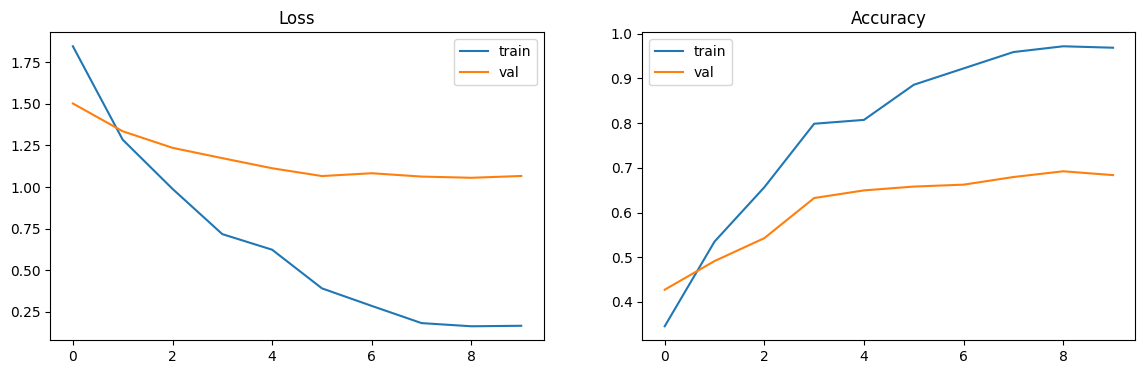

In [ ]:
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model_2.parameters()), lr=0.001, momentum=0.9)
exp_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model_2,dict_res_2 = train_model(model_2.to('cuda'),
                    dataloaders,
                       criterion,
                       optimizer,
                       exp_scheduler,
                       num_epochs=num_epochs,
                       silent=True)

plot_convergence(dict_res_2,num_epochs ); plt.show()


### Comments:

Here we fixed only CNN layers and result already impouved vs all fixed, but still worse than when we fune-time all od them

### (2.2) Fix: first 7 layers

In [ ]:
# Load a model
model_3 = models.vgg16(pretrained=True)
model_3.classifier[6] = nn.Linear(in_features=4096, out_features=9)

# fix the weights
for i in range(7):
  for param in model_3.features[i].parameters():
      param.requires_grad = False

summary(model_3.to(device), (3, 256, 256))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
             ReLU-14          [-1, 256,

Epoch 0/9
----------
Epoch 1/9
----------
Epoch 2/9
----------
Epoch 3/9
----------
Epoch 4/9
----------
Epoch 5/9
----------
Epoch 6/9
----------
Epoch 7/9
----------
Epoch 8/9
----------
Epoch 9/9
----------
Training complete in 2m 42s
Best val Acc: 0.799145


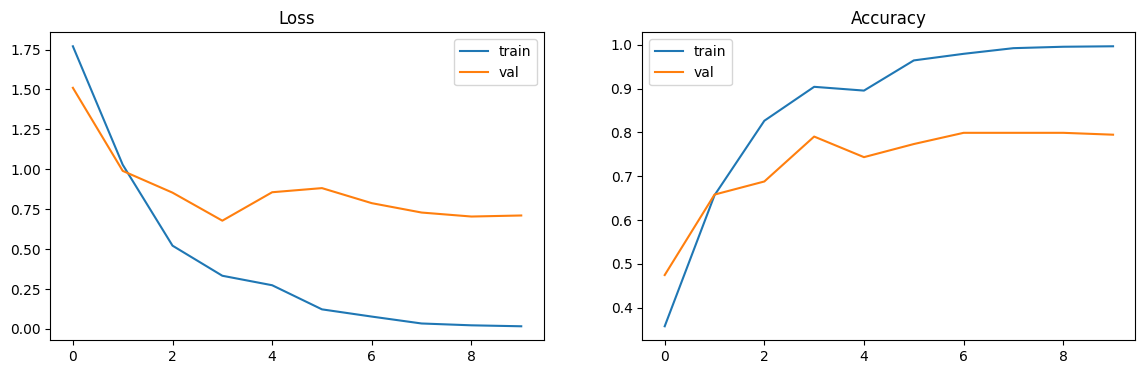

In [ ]:
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model_3.parameters()), lr=0.001, momentum=0.9)
exp_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model_3,dict_res_3 = train_model(model_3.to('cuda'),
                    dataloaders,
                       criterion,
                       optimizer,
                       exp_scheduler,
                       num_epochs=num_epochs,
                       silent=True)

plot_convergence(dict_res_3,num_epochs ); plt.show()


###(2.3) Fix first 11 layers

In [ ]:
# Load a model
model_2_3 = models.vgg16(pretrained=True)
model_2_3.classifier[6] = nn.Linear(in_features=4096, out_features=9)

# fix the weights
for i in range(12):
  for param in model_2_3.features[i].parameters():
      param.requires_grad = False

summary(model_2_3.to(device), (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
             ReLU-14          [-1, 256,

Epoch 0/9
----------
Epoch 1/9
----------
Epoch 2/9
----------
Epoch 3/9
----------
Epoch 4/9
----------
Epoch 5/9
----------
Epoch 6/9
----------
Epoch 7/9
----------
Epoch 8/9
----------
Epoch 9/9
----------
Training complete in 2m 24s
Best val Acc: 0.816239


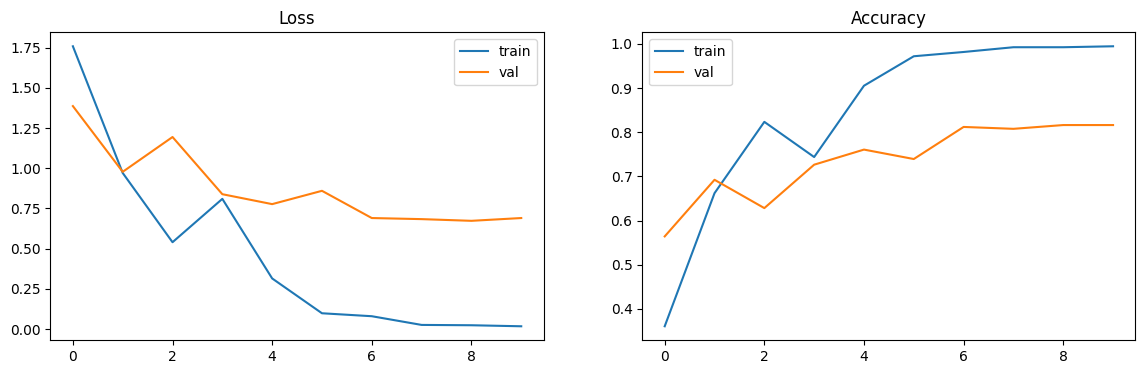

In [ ]:
model_2_3, dict_res_2_3 = run_model(model_2_3)

### (2.4) Fix first 25 layers

In [ ]:
# Load a model
model_2_4 = models.vgg16(pretrained=True)
model_2_4.classifier[6] = nn.Linear(in_features=4096, out_features=9)

# fix the weights
for i in range(12):
  for param in model_2_4.features[i].parameters():
      param.requires_grad = False

summary(model_2_4.to(device), (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
             ReLU-14          [-1, 256,

Epoch 0/9
----------
Epoch 1/9
----------
Epoch 2/9
----------
Epoch 3/9
----------
Epoch 4/9
----------
Epoch 5/9
----------
Epoch 6/9
----------
Epoch 7/9
----------
Epoch 8/9
----------
Epoch 9/9
----------
Training complete in 2m 25s
Best val Acc: 0.833333


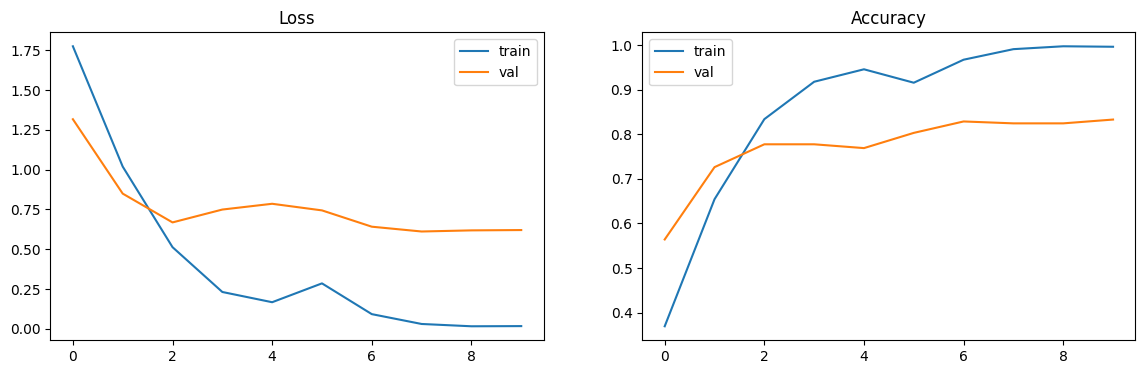

In [ ]:
model_2_4, dict_res_2_4 = run_model(model_2_4)

### (2.5) Fix last 3 convolution layers

In [ ]:
# Load a model
model_2_5 = models.vgg16(pretrained=True)
model_2_5.classifier[6] = nn.Linear(in_features=4096, out_features=9)

# fix the weights
for i in range(24, 31):
  for param in model_2_5.features[i].parameters():
      param.requires_grad = False

summary(model_2_5.to(device), (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
             ReLU-14          [-1, 256,

Epoch 0/9
----------
Epoch 1/9
----------
Epoch 2/9
----------
Epoch 3/9
----------
Epoch 4/9
----------
Epoch 5/9
----------
Epoch 6/9
----------
Epoch 7/9
----------
Epoch 8/9
----------
Epoch 9/9
----------
Training complete in 3m 22s
Best val Acc: 0.807692


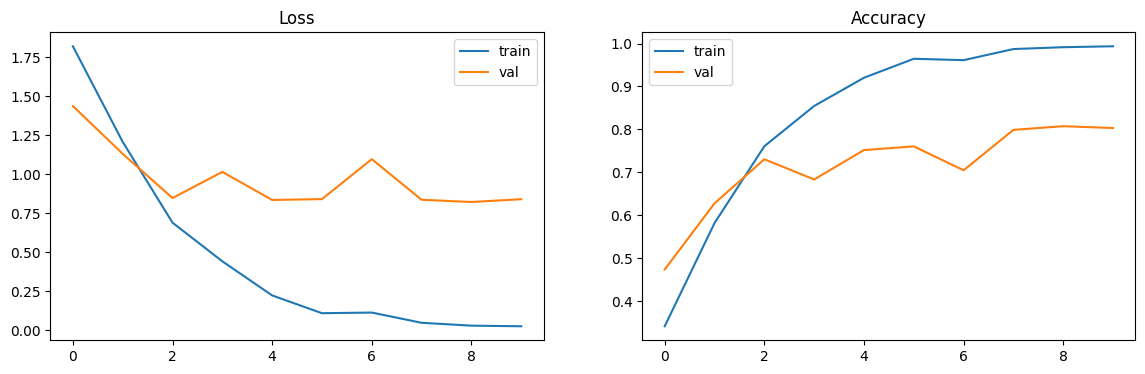

In [ ]:
model_2_5, dict_res_2_5 = run_model(model_2_5)

### Comparison

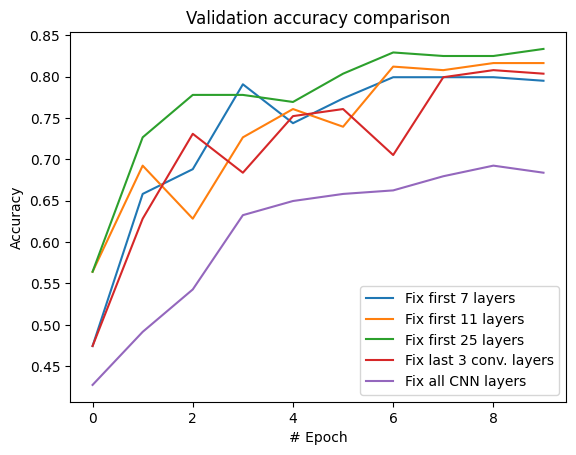

In [ ]:
plt.plot(dict_res_3['val'][1], label='Fix first 7 layers')
plt.plot(dict_res_2_3['val'][1], label='Fix first 11 layers')
plt.plot(dict_res_2_4['val'][1], label='Fix first 25 layers')
plt.plot(dict_res_2_5['val'][1], label='Fix last 3 conv. layers')
plt.plot(dict_res_2['val'][1], label='Fix all CNN layers')
plt.title('Validation accuracy comparison')
plt.xlabel('# Epoch')
plt.ylabel('Accuracy')
plt.legend();

In [ ]:
mkdir data


We can see that we get the best results when only we allow more layers to undergo fine-tuning

## (3) Using a pretrained model - fixed some feature, from scrach the rest (30 points)

Use pre-trained VGG16 model with fixed weights of **only part of the layers**. **Initialize randomely** the rest of the layers. You should try different amount of layers as you wish. Try to get your best results.

### (3.1) Fix CNN, random full connected layers

In [ ]:
# Load a model
model_r1 = models.vgg16(pretrained=False)
model_r1.classifier[6] = nn.Linear(in_features=4096, out_features=9)


# fix the weights
for i in range(29):
  for param in model_r1.features[i].parameters():
      param.requires_grad = False

# for i in range(6):
#   for param in model_r1.classifier[i].parameters():
#       param.requires_grad = False

# re-init layers with random layers
model_r1.classifier = nn.Sequential(
    nn.Linear(in_features=25088, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=4096, bias=True))


summary(model_r1.to(device), (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
             ReLU-14          [-1, 256,

Epoch 0/9
----------
Epoch 1/9
----------
Epoch 2/9
----------
Epoch 3/9
----------
Epoch 4/9
----------
Epoch 5/9
----------
Epoch 6/9
----------
Epoch 7/9
----------
Epoch 8/9
----------
Epoch 9/9
----------
Training complete in 1m 41s
Best val Acc: 0.256410


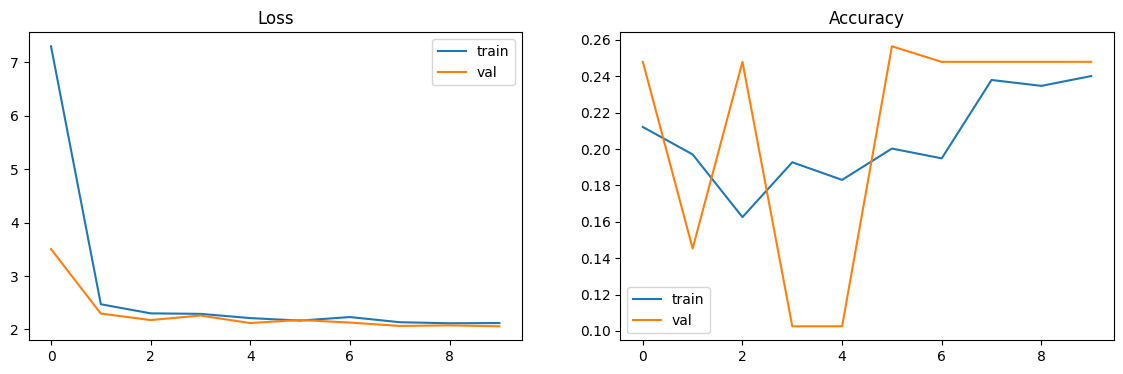

In [ ]:

# train a model
optimizer_ft = optim.SGD(filter(lambda p: p.requires_grad, model_r1.parameters()), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_r1, dict_res_r1 = train_model(model_r1.to('cuda'),
                    dataloaders,
                       criterion,
                       optimizer_ft,
                       exp_lr_scheduler,
                       num_epochs=num_epochs,
                       silent=True)

plot_convergence(dict_res_r1,num_epochs ); plt.show()


#### Comments:

Here we fixed all CNN layers and define all the full-conected randomly and so far it is the wrost result that we see )

### (3.2) Fix first 7 of the CNN layers, random others

In [ ]:
# Load a model
model_r2 = models.vgg16(pretrained=False)
model_r2.classifier[6] = nn.Linear(in_features=4096, out_features=9)


# fix the weights
for i in range(7):
  for param in model_r2.features[i].parameters():
      param.requires_grad = False

# for i in range(6):
#   for param in model_r1.classifier[i].parameters():
#       param.requires_grad = False

model_r2.features[10] = nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
model_r2.features[12] =  nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
model_r2.features[14] = nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
model_r2.features[17] =  nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
model_r2.features[19] = nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
model_r2.features[21] =  nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
model_r2.features[24] =  nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
model_r2.features[26] =  nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
model_r2.features[28] = nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

# re-init layers with random layers
model_r2.classifier = nn.Sequential(
    nn.Linear(in_features=25088, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=4096, bias=True))


summary(model_r2.to(device), (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
             ReLU-14          [-1, 256,

Epoch 0/9
----------
Epoch 1/9
----------
Epoch 2/9
----------
Epoch 3/9
----------
Epoch 4/9
----------
Epoch 5/9
----------
Epoch 6/9
----------
Epoch 7/9
----------
Epoch 8/9
----------
Epoch 9/9
----------
Training complete in 2m 41s
Best val Acc: 0.247863


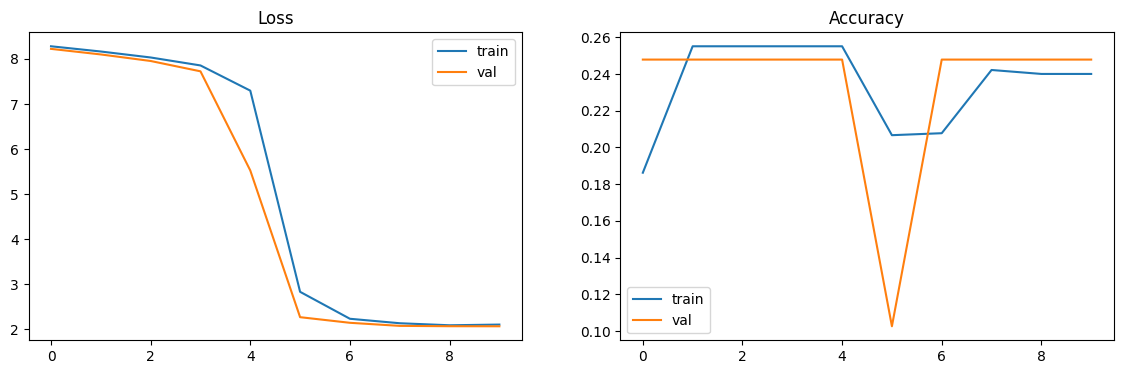

In [ ]:

# train a model
optimizer_ft = optim.SGD(filter(lambda p: p.requires_grad, model_r2.parameters()), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_r2,dict_res_r2 = train_model(model_r2.to('cuda'),
                    dataloaders,
                       criterion,
                       optimizer_ft,
                       exp_lr_scheduler,
                       num_epochs=num_epochs,
                       silent=True)

plot_convergence(dict_res_r2,num_epochs ); plt.show()


### (3.3) Fix all layers but the 2 last FC layers

In [ ]:
# Load a model
model_r3 = models.vgg16(pretrained=False)
model_r3.classifier[6] = nn.Linear(in_features=4096, out_features=9)


# fix the weights of feature
for param in model_r3.features.parameters():
    param.requires_grad = False

# fix the weights of classifier
for param in model_r3.classifier.parameters():
    param.requires_grad = False

model_r3.classifier[3] = nn.Linear(in_features=4096, out_features=4096, bias=True)


summary(model_r3.to(device), (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
             ReLU-14          [-1, 256,

Epoch 0/9
----------
Epoch 1/9
----------
Epoch 2/9
----------
Epoch 3/9
----------
Epoch 4/9
----------
Epoch 5/9
----------
Epoch 6/9
----------
Epoch 7/9
----------
Epoch 8/9
----------
Epoch 9/9
----------
Training complete in 1m 30s
Best val Acc: 0.247863


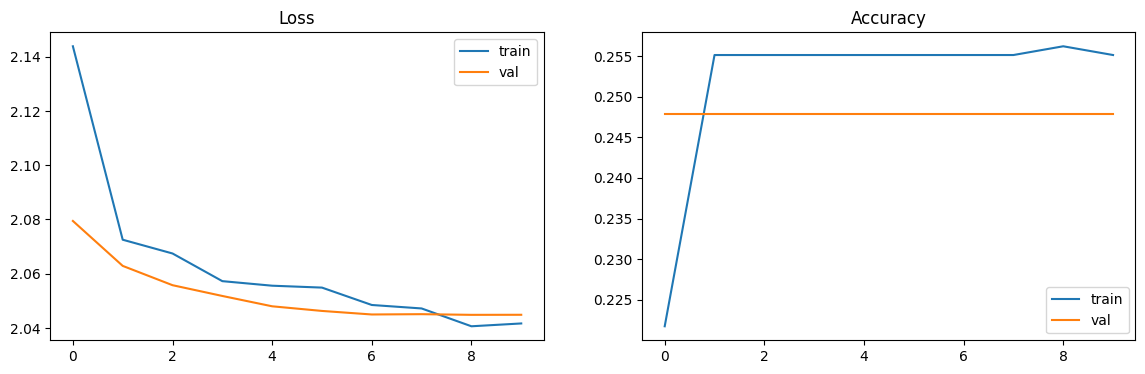

In [ ]:
model_r3, dict_res_r3 = run_model(model_r3)

In the above graph we can see some learning, but with little success.
Let's try to add more epochs and to increase the learning rate

### (3.4) Fix all layers but the 2 last FC layers - increasing learning rate and adding epochs

Epoch 0/19
----------
Epoch 1/19
----------
Epoch 2/19
----------
Epoch 3/19
----------
Epoch 4/19
----------
Epoch 5/19
----------
Epoch 6/19
----------
Epoch 7/19
----------
Epoch 8/19
----------
Epoch 9/19
----------
Epoch 10/19
----------
Epoch 11/19
----------
Epoch 12/19
----------
Epoch 13/19
----------
Epoch 14/19
----------
Epoch 15/19
----------
Epoch 16/19
----------
Epoch 17/19
----------
Epoch 18/19
----------
Epoch 19/19
----------
Training complete in 3m 3s
Best val Acc: 0.256410


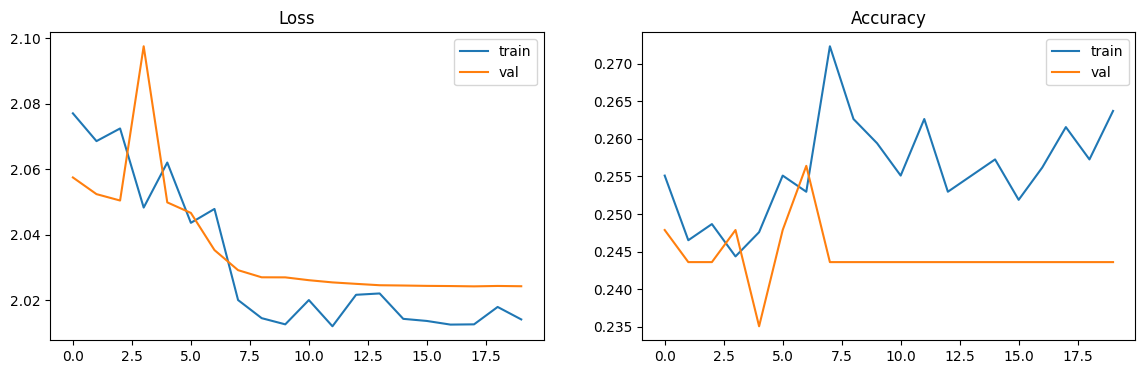

In [ ]:
# Load a model
model_r3_2 = models.vgg16(pretrained=False)
model_r3_2.classifier[6] = nn.Linear(in_features=4096, out_features=9)


# fix the weights of feature
for param in model_r3_2.features.parameters():
    param.requires_grad = False

# fix the weights of classifier
for param in model_r3_2.classifier.parameters():
    param.requires_grad = False

model_r3_2.classifier[3] = nn.Linear(in_features=4096, out_features=4096, bias=True)

model_r3_2, dict_res_r3_2 = run_model(model_r3, num_epochs=20, lr=0.01)

The higher learning rate and the additional epochs did not imporve the learning.

### Comparison

It seems that our dataset is too small to learn on the random weights :(

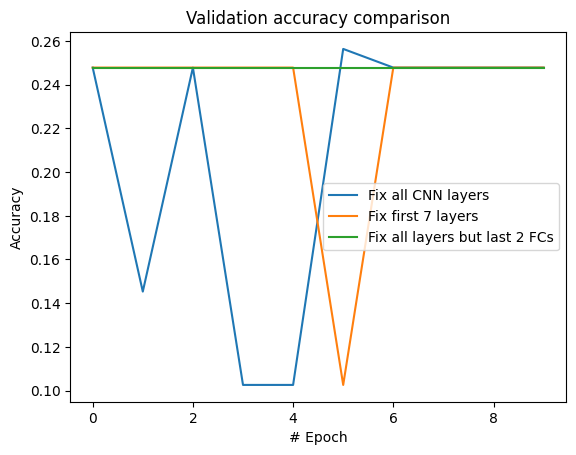

In [ ]:
plt.plot(dict_res_r1['val'][1], label='Fix all CNN layers')
plt.plot(dict_res_r2['val'][1], label='Fix first 7 layers')
plt.plot(dict_res_r3['val'][1], label='Fix all layers but last 2 FCs')
plt.title('Validation accuracy comparison')
plt.xlabel('# Epoch')
plt.ylabel('Accuracy')
plt.legend();

## (4) Using a model - only architecture (from scrach) (10 points)

In this part we will train the model from scrach. Means that we do not use a pre-trained weights at all, only "steal" the architecture of VGG16.

Epoch 0/9
----------
Epoch 1/9
----------
Epoch 2/9
----------
Epoch 3/9
----------
Epoch 4/9
----------
Epoch 5/9
----------
Epoch 6/9
----------
Epoch 7/9
----------
Epoch 8/9
----------
Epoch 9/9
----------
Training complete in 3m 27s
Best val Acc: 0.320513


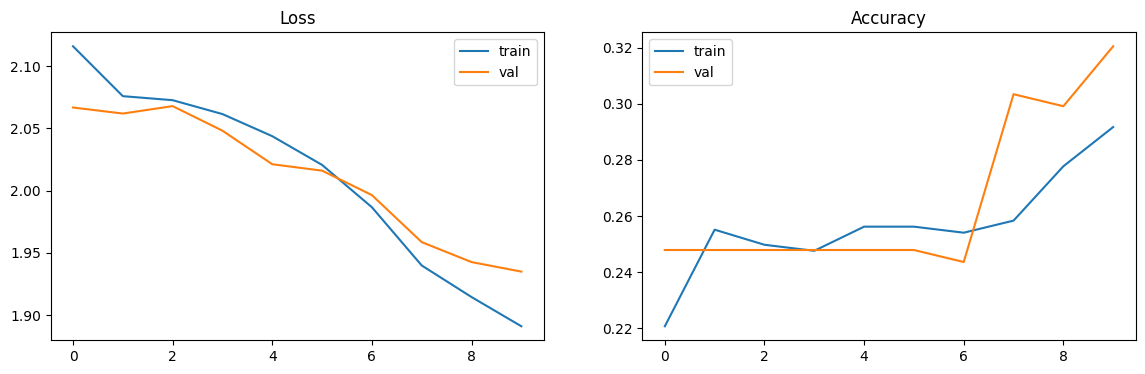

In [ ]:
# Load a model
model_a = models.vgg16(pretrained=False)
model_a.classifier[6] = nn.Linear(in_features=4096, out_features=9)

# train a model
optimizer_ft = optim.SGD(filter(lambda p: p.requires_grad, model_a.parameters()), lr=0.01, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_a,dict_res_a = train_model(model_a.to('cuda'),
                    dataloaders,
                       criterion,
                       optimizer_ft,
                       exp_lr_scheduler,
                       num_epochs=num_epochs,
                       silent=True)

plot_convergence(dict_res_a,num_epochs ); plt.show()


Let's increase the number of epochs

Epoch 0/19
----------
train Loss: 2.1029 Acc: 0.2347
val Loss: 2.1114 Acc: 0.2479

Epoch 1/19
----------
train Loss: 2.0732 Acc: 0.2551
val Loss: 2.0521 Acc: 0.2479

Epoch 2/19
----------
train Loss: 2.0675 Acc: 0.2551
val Loss: 2.0561 Acc: 0.2479

Epoch 3/19
----------
train Loss: 2.0566 Acc: 0.2551
val Loss: 2.0444 Acc: 0.2479

Epoch 4/19
----------
train Loss: 2.0245 Acc: 0.2540
val Loss: 1.9948 Acc: 0.2521

Epoch 5/19
----------
train Loss: 2.0228 Acc: 0.2519
val Loss: 1.9926 Acc: 0.2479

Epoch 6/19
----------
train Loss: 1.9841 Acc: 0.2594
val Loss: 1.9579 Acc: 0.2692

Epoch 7/19
----------
train Loss: 1.9342 Acc: 0.2799
val Loss: 1.9133 Acc: 0.2991

Epoch 8/19
----------
train Loss: 1.8893 Acc: 0.3025
val Loss: 1.9042 Acc: 0.3077

Epoch 9/19
----------
train Loss: 1.8735 Acc: 0.3100
val Loss: 1.8973 Acc: 0.3248

Epoch 10/19
----------
train Loss: 1.8648 Acc: 0.3219
val Loss: 1.8947 Acc: 0.3419

Epoch 11/19
----------
train Loss: 1.8506 Acc: 0.3283
val Loss: 1.8834 Acc: 0.3462

Ep

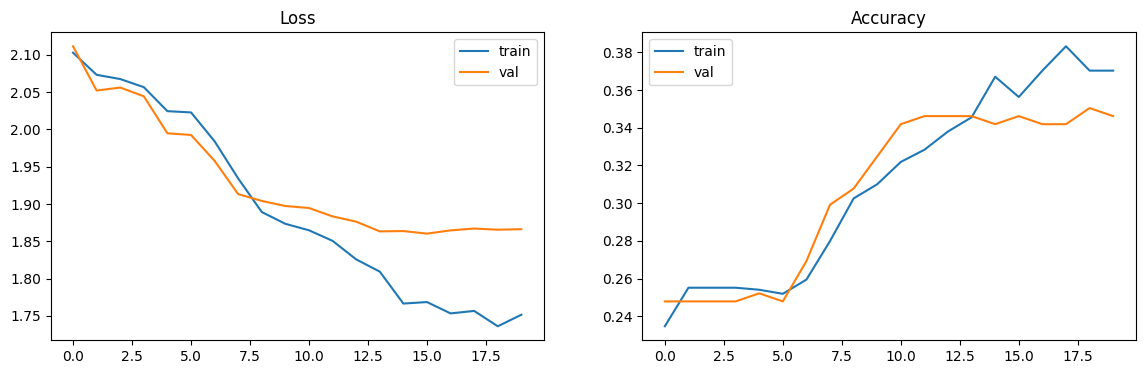

In [ ]:
num_epochs = 20

# Load a model
model_a2 = models.vgg16(pretrained=False)
model_a2.classifier[6] = nn.Linear(in_features=4096, out_features=9)

# train a model
optimizer_ft = optim.SGD(filter(lambda p: p.requires_grad, model_a2.parameters()), lr=0.01, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_a2, dict_res_a2 = train_model(model_a2.to('cuda'),
                    dataloaders,
                       criterion,
                       optimizer_ft,
                       exp_lr_scheduler,
                       num_epochs=num_epochs,
                       silent=False)

plot_convergence(dict_res_a2, num_epochs); plt.show()

### Comments:

Even with more epochs, trying to learn from scratch on our data is not good idea since we have not so much data.


So, in our example the best result we could get if we use pretrained model on a large dataset that learned some more general features and retrain it on our small data to get more accurate results.